# Introduction 
* This code is adapted from the example provided in the python optimal transport package:
https://pythonot.github.io/auto_examples/backends/plot_wass2_gan_torch.html#sphx-glr-auto-examples-backends-plot-wass2-gan-torch-py

## Imports

In [1]:
%matplotlib inline
%matplotlib widget
# import sys
# !{sys.executable} -m pip install pot
# !{sys.executable} -m pip install ipympl 
# !{sys.executable} -m pip install ipywidgets

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch import nn
import ot

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

torch.manual_seed(126) # 125 looks p good 

__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4080
__CUDA Device Total Memory [GB]: 16.860184576


## Data generation

In [2]:
sigma = 0.0
n_dims = 3
n_features = 2

# sample data (uniform grid on cube)
def get_data(n_samples):
    c1 = torch.arange(1, n_samples+1) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)
    c3 = torch.arange(1, n_samples+1) / (n_samples)

    c = torch.cartesian_prod(c1,c2, c3)
    x = c
    return x

## Plot data



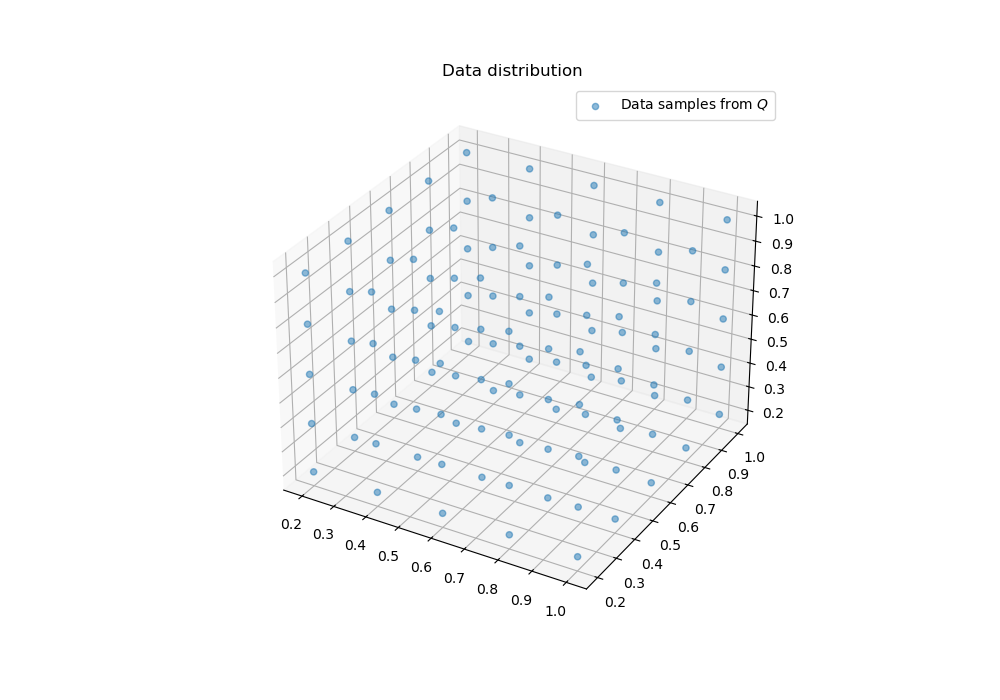

In [3]:
from mpl_toolkits import mplot3d

# plot the distributions
x = get_data(5)
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
plt.title("simple 3D scatter plot")
ax.scatter3D(x[:, 0], x[:, 1], x[:, 2], label='Data samples from $Q$', alpha=0.5)
plt.title('Data distribution')
plt.legend()
plt.show()


## Generator Model



In [4]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 2
        self.n_out = 3
        leaky = 0.00001
        w_layer = 150
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, w_layer),
            nn.LeakyReLU(leaky),
            nn.Linear(w_layer, w_layer),
            nn.LeakyReLU(leaky),
            nn.Linear(w_layer, w_layer),
            nn.LeakyReLU(leaky),
        )
        # add more hidden layers 
        for i in range(0,4):
            temp = nn.Sequential(
                nn.Linear(w_layer, w_layer),
                nn.LeakyReLU(leaky),
            )
            self.model.append(temp)
            
        self.model.append(nn.Linear(w_layer, self.n_out))
        
    def forward(self, x):
        x = self.model(x)
        return x


## Training the model



In [5]:
G = Generator()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5)

# number of iteration and size of the batches
n_iter = 1000 
size_batch = 10

# generate static samples to see their trajectory along training
n_visu = 2000
xnvisu = torch.rand(n_visu, n_features)
xvisu = torch.zeros(n_iter, n_visu, n_dims)

ab = torch.ones(size_batch**3) / size_batch**3
losses = []


for i in range(n_iter):

    # generate noise samples
    xn = torch.rand(size_batch**3, n_features) # just gives size_batch correctly

    # generate data samples
    xd = get_data(size_batch) # constant across iterations (uniform grid) 

    # generate sample along iterations
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    xg = G(xn)
    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))

    if i % 10 == 0:
        print("Iter: {:3d}, loss={}".format(i, losses[-1]))

    loss.backward()
    optimizer.step()

    del M


Iter:   0, loss=1.0440324544906616
Iter:  10, loss=0.20644594728946686
Iter:  20, loss=0.2413288801908493
Iter:  30, loss=0.2009730041027069
Iter:  40, loss=0.18486954271793365
Iter:  50, loss=0.17593948543071747
Iter:  60, loss=0.18061967194080353
Iter:  70, loss=0.1772453784942627
Iter:  80, loss=0.17412200570106506
Iter:  90, loss=0.17224937677383423
Iter: 100, loss=0.17005254328250885
Iter: 110, loss=0.16946099698543549
Iter: 120, loss=0.1690749078989029
Iter: 130, loss=0.1673145890235901
Iter: 140, loss=0.16751214861869812
Iter: 150, loss=0.1667928844690323
Iter: 160, loss=0.1672419011592865
Iter: 170, loss=0.16558533906936646
Iter: 180, loss=0.16937601566314697
Iter: 190, loss=0.16549769043922424
Iter: 200, loss=0.16489499807357788
Iter: 210, loss=0.16768062114715576
Iter: 220, loss=0.16549180448055267
Iter: 230, loss=0.16161353886127472
Iter: 240, loss=0.15852999687194824
Iter: 250, loss=0.15093392133712769
Iter: 260, loss=0.13719028234481812
Iter: 270, loss=0.11551254987716675


## Plot Loss

Text(0.5, 0, 'Iterations')

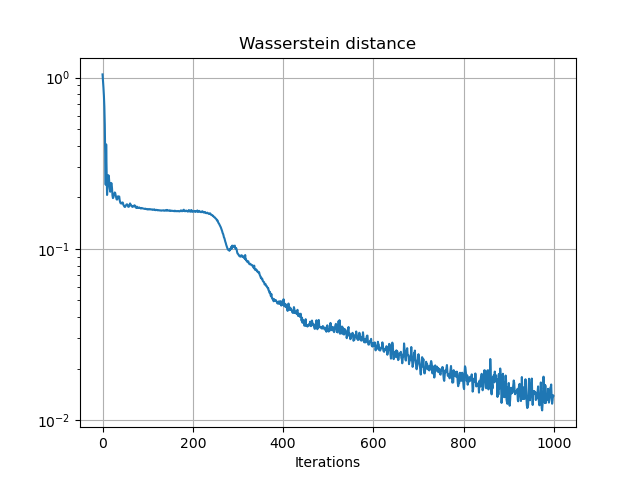

In [10]:
plt.figure()
plt.gcf().set_dpi(100) # 300 for paper
plt.semilogy(losses)
plt.grid()
plt.title('Wasserstein distance')
plt.xlabel("Iterations")

## Plot trajectories of generated samples along iterations



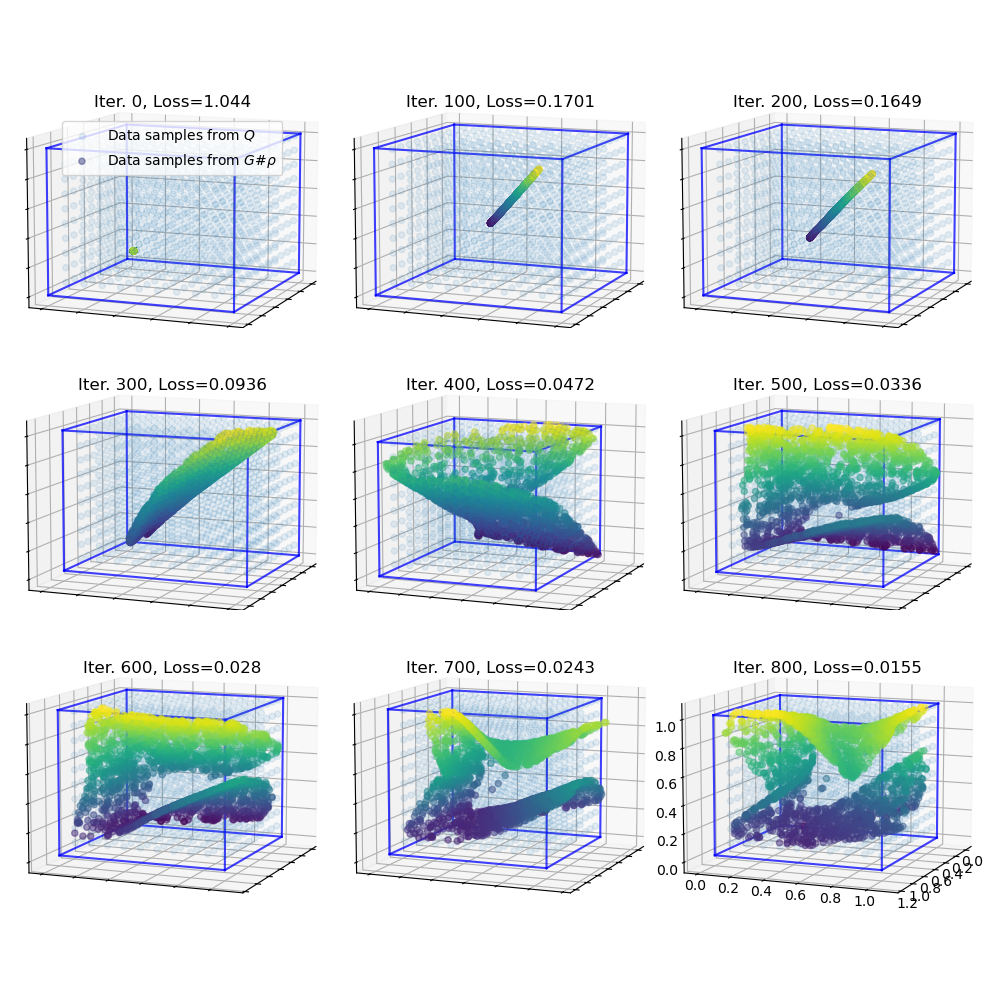

In [9]:
plt.clf()
plt.close('all')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 200 for paper 

ivisu = [0, 100, 200, 300, 400, 500, 600, 700, 800] 

# Create a figure and a 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10), subplot_kw={'projection': '3d'}, edgecolor='none')
# fig.tight_layout(pad=1.0)

# Iterate over each subplot to convert it into 3D and plot something
for i, ax in enumerate(axs.flat):

    # Adjust the spacing between plots
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-.05, hspace=-.35)

    # set distance to z-height
    distances = xvisu[ivisu[i], :, 2]

    # use z-height to map to colors
    colors = distances

    # plot data 
    ax.scatter3D(xd[:, 0], xd[:, 1], xd[:, 2], label='Data samples from $Q$', alpha=0.1)
    ax.scatter3D(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], xvisu[ivisu[i], :, 2],
                 label=r'Data samples from $G\#\rho$', 
                 alpha=0.5,
                 c = distances,
                 cmap='viridis'
                 )

    # define unit cube
    vertices = [(0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0),
                (0, 0, 1), (1, 0, 1), (1, 1, 1), (0, 1, 1)]

    # define the edges
    edges = [(0, 1), (1, 2), (2, 3), (3, 0),
            (4, 5), (5, 6), (6, 7), (7, 4),
            (0, 4), (1, 5), (2, 6), (3, 7)]

    # plot edges 
    for edge in edges:
        # get points for each edge 
        start, end = edge
        points = [vertices[start], vertices[end]]
        # convert points to format suitable for plotting
        x, y, z = zip(*points)
        # plot 
        ax.plot(x, y, z, color='b', alpha = .75)
    
    # set view 
    ax.view_init(10, 22, 0) 

    # set titles and labels, see issue https://github.com/matplotlib/matplotlib/issues/16805/
    ax.set_title(f'Iter. {ivisu[i]}, Loss={round(losses[ivisu[i]], 4)}', pad=-25, y=1.000001) # need the 1.00001 to turn off auto 

    # adjust legend 
    if i == 0:
        ax.legend(bbox_to_anchor=(.5, .7), loc='center', borderaxespad=0) # bbox in coordinates 
    
    # only keep labels on third figure of each row 
    if (i != 8): 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if (i == 8): # readjust x axis to be closer 
        ax.xaxis.set_tick_params(pad=-4)
        ax.yaxis.set_tick_params(pad=-5)
        ax.zaxis.set_tick_params(pad=-1)

plt.show()



## Generate and visualize data - 2x3



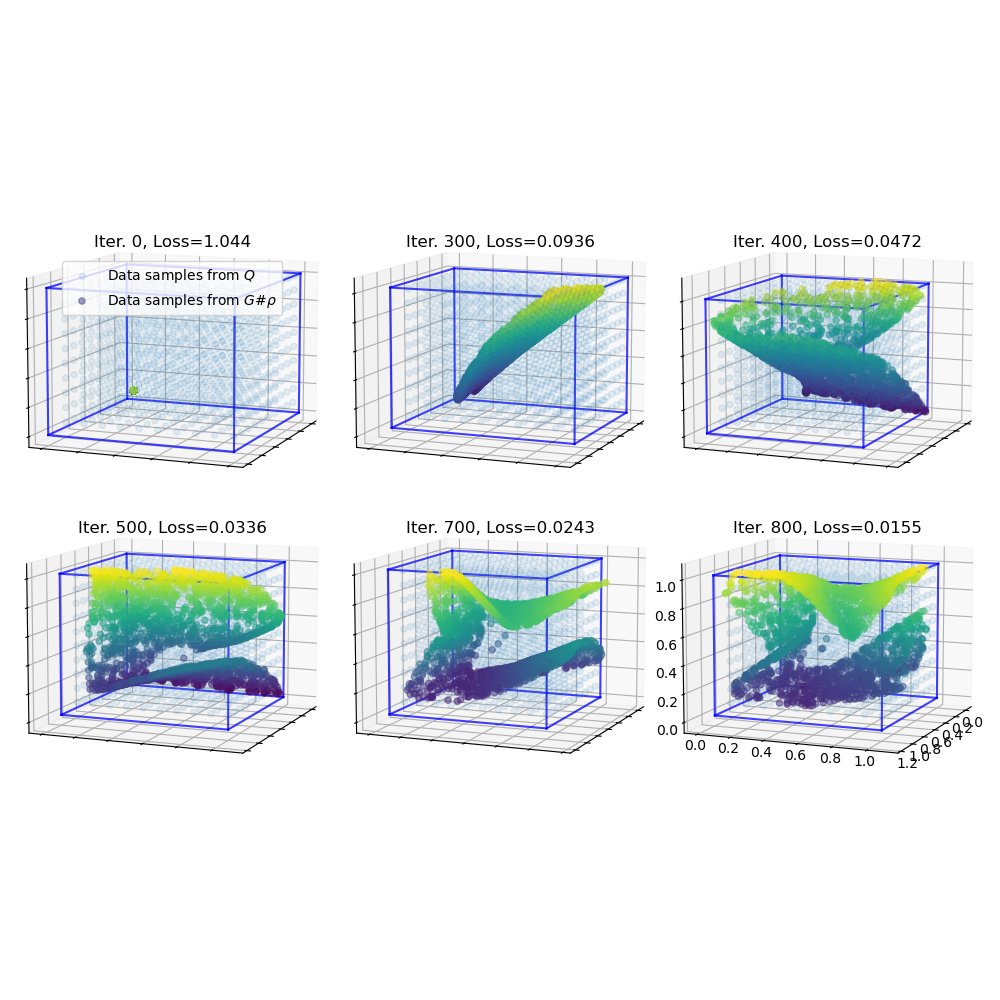

No such comm: 3cfd8c0b4ac743829d6c8a9d268a3750


In [8]:
plt.clf()
plt.close('all')
mpl.rcParams['figure.dpi'] = 100 # 200 for paper 

ivisu = [0, 300, 400, 500,700, 800] 


# Create a figure and a 3x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(10, 10), subplot_kw={'projection': '3d'}, edgecolor='none')
# fig.tight_layout(pad=1.0)

# Iterate over each subplot to convert it into 3D and plot something
for i, ax in enumerate(axs.flat):

    # adjust spacing between plots
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-.05, hspace=-.6)

    # calculate z-height 
    distances = xvisu[ivisu[i], :, 2]

    # use z-height to color 
    colors = distances

    ax.scatter3D(xd[:, 0], xd[:, 1], xd[:, 2], label='Data samples from $Q$', alpha=0.1)
    ax.scatter3D(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], xvisu[ivisu[i], :, 2],
                 label=r'Data samples from $G\#\rho$', 
                 alpha=0.5,
                 c = distances,
                 cmap='viridis'
                 )

    # define unit cube 
    vertices = [(0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0),
                (0, 0, 1), (1, 0, 1), (1, 1, 1), (0, 1, 1)]

    # define the edges 
    edges = [(0, 1), (1, 2), (2, 3), (3, 0),
            (4, 5), (5, 6), (6, 7), (7, 4),
            (0, 4), (1, 5), (2, 6), (3, 7)]

    # plot edges 
    for edge in edges:
        # get the points from each edge 
        start, end = edge
        points = [vertices[start], vertices[end]]
        # convert points to format suitable for plotting
        x, y, z = zip(*points)
        # plot 
        ax.plot(x, y, z, color='b', alpha = .75)

    # set plot view 
    ax.view_init(10, 22, 0) 

    # set titles and labels, see issue https://github.com/matplotlib/matplotlib/issues/16805/
    ax.set_title(f'Iter. {ivisu[i]}, Loss={round(losses[ivisu[i]], 4)}', pad=-25, y=1.000001) # need the 1.00001 to turn off auto 

    # adjust legend 
    if i == 0:
        ax.legend(bbox_to_anchor=(.5, .7), loc='center', borderaxespad=0) # bbox in coordinates 
    
    # only keep labels on final figure 
    if (i != 5): 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if (i == 5): # readjust x axis to be closer 
        ax.xaxis.set_tick_params(pad=-4)
        ax.yaxis.set_tick_params(pad=-5)
        ax.zaxis.set_tick_params(pad=-1)

plt.show()

